In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

import llops.operators as ops
import llops as yp
from llops import vec

In [2]:
global_backend = 'numpy' # arrayfire or numpy
global_dtype = 'complex32' # complex32 or complex64

ops.setDefaultBackend(global_backend)
ops.setDefaultDatatype(global_dtype)

<IPython.core.display.Javascript object>


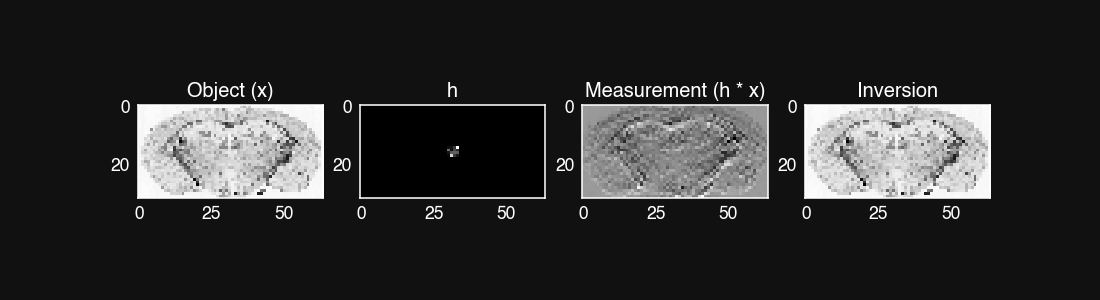

In [5]:
# Image to use when generating object
object_file_name = '../test/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Image size to simulate
image_size = np.array([32, 64])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
x_0 = yp.simulation.brain(image_size)

# Convert object to global default backend
x = yp.changeBackend(x_0)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(yp.abs(h)))

C = ops.Convolution(h, pad_value='mean')
A = C
y = A * x

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x_0, 'numpy')))
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)))
plt.title('h')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))))
plt.title('Measurement (h * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(A.inv * y))))
plt.title('Inversion');

## Crop Outside of FOV

<IPython.core.display.Javascript object>


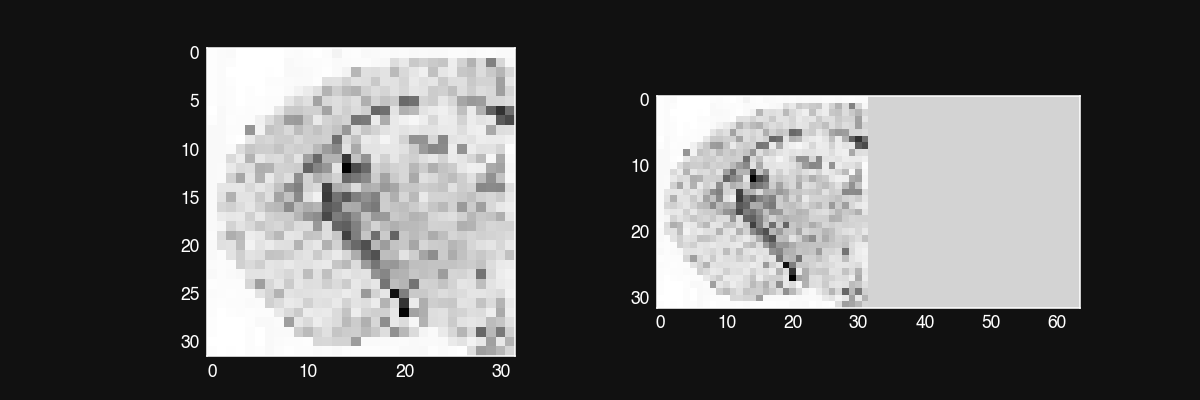

In [6]:
crop_size = (32, 32)
CR = ops.Crop(image_size, crop_size, crop_start=(0,0),pad_value='mean')

CR.arguments = {'crop_offset': (-1,-10)}

x_crop = CR * x

plt.figure()
plt.subplot(121)
plt.imshow(yp.abs(CR * x))
plt.subplot(122)
plt.imshow(yp.abs(CR.H * CR * x))

## Pad Outside FOV

In [ ]:
crop_size = (32, 32)
CR = ops.Crop(image_size, crop_size, crop_start=(0,0))

CR.arguments = {'crop_offset': (2,33)}

x_crop = CR * x

CR.H * x_crop

In [ ]:
crop_size = (32, 32)
CR = ops.Crop(image_size, crop_size, crop_start=(0,0))

CR.arguments = {'crop_offset': (2,33)}

x_crop = CR * x

plt.figure()
plt.subplot(121)
plt.imshow(yp.abs(CR * x))
plt.subplot(122)
plt.imshow(yp.abs(CR.H * CR * x))

## Make Convolution Smarter
Helper functions required:
- isDeltaFunction: Takes array, determines if it's a delta function, and gets it's position

In [ ]:
sz = yp.shape(x)
kernel = yp.zeros(sz)   
# kernel[50,50] = 10
kernel[20,21] = 1
# kernel[20,31] = 0.5

C1 = ops.Convolution(kernel, force_full_convolution=True)
C2 = ops.Convolution(kernel)
print(C1)
print(C2)

plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(yp.abs(x))
plt.colorbar()

plt.subplot(132)
plt.imshow(yp.abs(C1 * x))
plt.colorbar()

plt.subplot(133)
plt.imshow(yp.abs(C2 * x))
plt.colorbar()

print(yp.amax(x))
print(yp.amax(yp.abs(C1 * x)))
print(yp.amax(yp.abs(C2 * x)))

np.sum(np.abs(C1 * x - C2 * x))

## Add Inner-Operators to Convolution
This will be removed if the operator is broken up

In [14]:
C = ops.Convolution(s0, inside_operator=F.H * H, mode='circular')

(32, 64)


In [11]:
s0

array([[0.+0.j],
       [0.+0.j]], dtype=complex64)

<IPython.core.display.Javascript object>


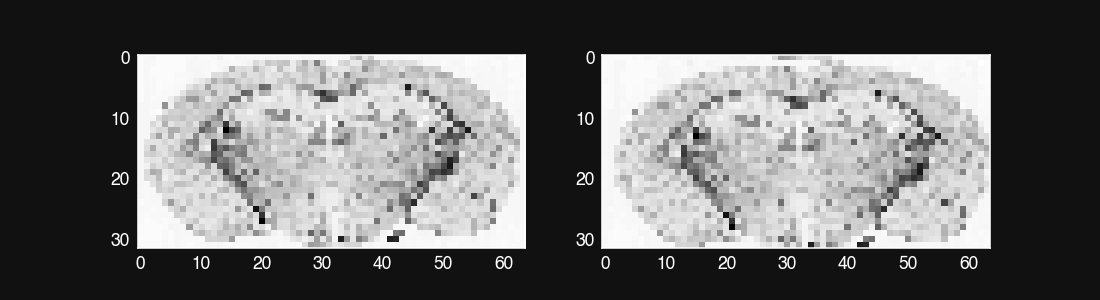

In [25]:
s0 = yp.zeros((2,1))
s1 = yp.ones((2,1)) * 1
H = ops.PhaseRamp(image_size)
F = ops.FourierTransform(image_size, center=True, pad=True)
C = ops.Convolution(s0, inside_operator=F.H * H, mode='circular')

C.arguments = {'kernel': s1}
plt.figure(figsize=(11,3))

plt.subplot(121)
plt.imshow(yp.abs(x))
plt.subplot(122)
plt.imshow(yp.abs(C * x))

## Inverting Single Operators

In [ ]:
F = ops.FourierTransform(h.shape)
A = F.H * ops.Diagonalize((F * h), inverse_regularizer=1e-10) * F
y = A * x
yp.abs(A.inv * y)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(yp.abs(x))
plt.colorbar()
plt.subplot(132)
plt.imshow(yp.abs(y))
plt.colorbar()
plt.subplot(133)
plt.imshow(yp.abs(A.inv * y))
plt.colorbar()

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse 
V = ops.Vstack(operators)
assert all(yp.vec(V.inv * (V * x)) == vec(x))

# Check gradient
V.gradient_check()

# Print latex
V.latex()
V.latex(gradient=True)

## Vertical Stacking and Inverses

In [ ]:
print(V.is_stack)

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse calculation
V = ops.Vstack(operators, normalize=False)

plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(V * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(V.H * V * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(V.inv * V * x))
plt.title('$A^{-1} A x$')
plt.colorbar()

## Applying Offsets to Crop Operators

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Set crop offsets
args = operators[1].arguments
args['crop_offset'] = (0,10)
operators[1].arguments = args

# Check inverse calculation
V = ops.Vstack(operators, normalize=False)

plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(V * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(V.H * V * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(V.inv * V * x))
plt.title('$A^{-1} A x$')
plt.colorbar()


## Applying Offsets to Stacked Crop Operators After Formation

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse calculation
V = ops.Vstack(operators, normalize=False)

# Set crop offsets
args = V.arguments
args[1]['crop_offset'] = (0,10)
operators[1].arguments = args

# Plot
plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(V * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(V.H * V * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(V.inv * V * x))
plt.title('$A^{-1} A x$')
plt.colorbar()

## Speed Optimization For Crop Operators

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse calculation
V = ops.Vstack(operators)
y = V * x

yy = yp.zeros(V.stack_operators[0].M)
%timeit V.stack_operators[0].H * yy + V.stack_operators[1].H * yy + V.stack_operators[2].H * yy
%timeit sum([V.stack_operators[i].H * y[V.idx[i]:V.idx[i + 1], :] for i in range(V.nops)])
%timeit V.H * y

## Inverting Diagonalized Operators

In [ ]:
# Convolution operators
c = ops.Convolution(h, inverse_regularizer=0)
conv_ops = [c] * 3

# Create operators
C = ops.Dstack(conv_ops)

# Create measurements
x3 = ops.VecStack([x] * 3)

# Composite Operator
y = C * ops.VecStack(x3)
C.latex()

# Perform inversion
x_star = C.inv * y

# Show results
plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x3))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(C * x3))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(C.H * C * x3))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(C.inv * C * x3))
plt.title('$A^{-1} A x$')
plt.colorbar()

## Combining Crops and Convolution Operators for Inversion

In [ ]:
# Crop operations
crop_ops = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
            ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
            ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Convolution operators
h_crop = crop_ops[1] * h#yp.rand(h.shape)
conv_ops = [ops.Convolution(h_crop, inverse_regularizer=0)] * 3

# Create operators
C = ops.Dstack(conv_ops)
X = ops.Vstack(crop_ops)

# Composite Operator
A = C * X
y = A * x
A.latex()

# Perform inversion
x_star = A.inv * y

# Show results
plt.figure(figsize=(14,4))
plt.subplot(151)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(152)
plt.imshow(yp.abs(A * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(153)
plt.imshow(yp.abs(A.H * A * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(154)
plt.imshow(yp.abs(A.inv * A * x))
plt.title('$A^{-1} A x$')
plt.colorbar()
plt.subplot(155)
plt.imshow(yp.abs(A.inv * A * x - x))
plt.title('$A^{-1} A x - x$')
plt.colorbar()

## Operator inside Diagonalize

In [ ]:
# Create phase ramp to diagonalize
H = ops.PhaseRamp(image_size)
s = yp.rand((2,1))

# Create diagonalized phase ramp operator
D = ops.Diagonalize(s, inside_operator=H)

# Check that inside operator is set correctly
assert yp.sum(yp.abs(D * x - ((H * s) * x))) == 0.0

# Check gradient
D.gradient_check()

# Render Latex
D.latex()

## Equality Testing

In [ ]:
D1 = ops.Diagonalize(h)
D_eq = ops.Diagonalize(h)
D_neq = ops.Diagonalize(yp.zeros_like(h))

# Ensure equality is correct
assert D1 == D_eq

# Ensure inequality is correct
assert not D1 == D_neq

F = ops.FourierTransform(image_size, center=True)
F_neq = ops.FourierTransform(image_size, center=False)
F_eq = ops.FourierTransform(image_size, center=True)
assert F == F_eq
assert not F == F_neq

assert F == F_eq
assert not F == F_neq